In [1]:
from tqdm import tqdm
from ReIDF import run_IDF

idf_files = ['/Users/rui.bo/Downloads/_Sub_/1.idf']
weather_file = '/Users/rui.bo/Downloads/EnergyPlus/GBR_SCT_Edinburgh.AP.031600_TMYx.2023.epw'
energyplus_exe = '/Applications/EnergyPlus-23-2-0/EnergyPlus'

output_folders = []
for idf_file in tqdm(idf_files, desc="E+ running", unit=".idf file"):
    output_folder = run_IDF(idf_file, weather_file, energyplus_exe=energyplus_exe)
    output_folders.append(output_folder)


E+ running: 100%|██████████| 1/1 [05:27<00:00, 327.26s/.idf file]

Simulation completed successfully.
Output Folder: /Users/rui.bo/Downloads/_Sub_/1


# Issue Tracker:
* Year Issue: 2023
* Move occupancy to Metering file (with a change of its name)

### Notes
> The temporal profiles incorporate vertical shading to distinguish non-working days, with two distinct transparency levels indicating different day categories. Saturdays are represented by light grey shading (α = 0.1), while Sundays and designated holidays appear with significantly reduced opacity (α = 0.05).

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os
plt.rcParams.update({
    'font.family': 'Arial',          # Set font to Arial
    'font.size': 14,                 # Default font size
    'axes.titlesize': 18,            # Title font size
    'axes.labelsize': 16,            # X and Y labels font size
    'xtick.labelsize': 16,           # X-axis tick labels font size
    'ytick.labelsize': 16,           # Y-axis tick labels font size
    'legend.fontsize': 16,           # Legend font size
    'legend.title_fontsize': 14,     # Legend title font size
    'figure.titlesize': 20           # Figure title font size (if using plt.suptitle)
})

In [57]:
def process_energy_data(csv_file):
    """Process energy data files with robust time handling"""
    df = pd.read_csv(csv_file)

    date_time_col = next((col for col in df.columns if "date" in col.lower() or "time" in col.lower()), None)
    
    if not date_time_col:
        raise ValueError(f"No Date/Time column found in {csv_file}")
    
    df = df.rename(columns={date_time_col: 'Date/Time'})
    time_str = df['Date/Time'].astype(str).str.replace(' 24:00:00', ' 00:00:00', regex=False)
    df['Date/Time'] = pd.to_datetime(time_str, errors='coerce')
    if df['Date/Time'].isna().any():
        df['Date/Time'] = pd.to_datetime('2023 ' + time_str, format='%Y %m/%d %H:%M:%S', errors='coerce')
            
    return df.dropna(subset=['Date/Time']).sort_values('Date/Time')

def process_metering_data(csv_file):
    """Process metering data with flexible timestamp parsing"""
    df = pd.read_csv(csv_file)
    time_col = next((col for col in df.columns if "timestamp" in col.lower() or "time" in col.lower()), 'Date/Time')
    df = df.rename(columns={time_col: 'Date/Time'})
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
    return df.dropna(subset=['Date/Time']).sort_values('Date/Time')

def profiling(parent_folder, start_date, end_date, energy_columns, metering_file, metering_column, 
              num_ticks=10, area=None, alpha=0.7, aux_column=None, aux_label="", aux_color="green", 
              aux_scale=1.0, aux_linestyle="-", aux_alpha=0.7, holidays=None):

    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    combined_data = []
    
    # Convert holidays to datetime objects
    holiday_dates = set()
    if holidays:
        for h in holidays:
            try:
                holiday_dates.add(pd.to_datetime(h).normalize())
            except ValueError:
                print(f"Warning: Could not parse holiday date: {h}")

    # Process simulation results
    for subfolder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, subfolder)
        energy_path = os.path.join(folder_path, "eplusmtr.csv")
        
        if os.path.exists(energy_path):
            try:
                energy_df = process_energy_data(energy_path)
                energy_df = energy_df.loc[energy_df['Date/Time'].between(start_dt, end_dt)].copy()
                energy_df['Simulation'] = subfolder
                energy_df['TimeDiff'] = energy_df['Date/Time'].diff().dt.total_seconds()
                energy_df['NewGroup'] = energy_df['TimeDiff'] > 3600  # 1 hour gap threshold
                combined_data.append(energy_df)
            except Exception as e:
                print(f"Error processing {subfolder}: {str(e)}")
    
    # Exit if no data found
    if not combined_data:
        print("No valid simulation data found")
        return
    
    combined_df = pd.concat(combined_data)
    metering_df = process_metering_data(metering_file)
    metering_df = metering_df.loc[metering_df['Date/Time'].between(start_dt, end_dt)]
    base_factor = 1 / 3.6e6  # J to kWh conversion
    if area and area > 0:
        base_factor /= area  # Add EUI normalization
        ylabel = 'EUI (kWh/m²)'
    else:
        ylabel = 'Energy (kWh)'
    
    # Generate comparison plots
    for energy_col in energy_columns:
        fig, ax1 = plt.subplots(figsize=(16, 8))
        for sim_name, group in combined_df.groupby('Simulation'):
            group['Segment'] = group['NewGroup'].cumsum()
            for segment_id, segment in group.groupby('Segment'):
                ax1.plot(
                    segment['Date/Time'], 
                    segment[energy_col] * base_factor,
                    label=sim_name if segment_id == 0 else "",
                    alpha=alpha
                )
        #-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        #-#-#--- Tick Ranges ---#-#-#
        ax1.set_xlim(start_dt, end_dt)
        ax1.set_ylim(0, 0.04)
        current = start_dt.normalize()
        one_day = pd.Timedelta(days=1)
        while current <= end_dt:
            if current in holiday_dates:
                ax1.axvspan(current, current + one_day, color='blue', alpha=0.05, zorder=0)
            elif current.weekday() == 5 and current not in holiday_dates:
                ax1.axvspan(current, current + one_day, color='blue', alpha=0.10, zorder=0)
            elif current.weekday() == 6 and current not in holiday_dates:
                ax1.axvspan(current, current + one_day, color='blue', alpha=0.15, zorder=0)
            current += one_day

        ax1.plot(
            metering_df['Date/Time'],
            metering_df[metering_column] * (1/area if area and area > 0 else 1),
            'r--', 
            label='Metering Data',
            linewidth=1.5,
            alpha=0.9
        )

        ax1.set_xlabel('Date and Time')
        ax1.set_ylabel(ylabel, color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_title(f'{energy_col} VS {aux_label if aux_column else ""}')

        if aux_column and aux_column in metering_df.columns:
            ax2 = ax1.twinx()
            ax2.plot(
                metering_df['Date/Time'],
                metering_df[aux_column] * aux_scale,
                color=aux_color,
                linestyle=aux_linestyle,
                alpha=aux_alpha,
                label=aux_label
            )
            ax2.set_ylabel(aux_label, color='black')
            ax2.tick_params(axis='y', labelcolor='black')
            #-#-#-#-#-#-#-#-#-#-#
            #--- Tick Ranges ---#
            ax2.set_ylim(0, 20)
            handles1, labels1 = ax1.get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            all_handles = handles1 + handles2
            all_labels = labels1 + labels2
        else:
            all_handles, all_labels = ax1.get_legend_handles_labels()
            if aux_column:
                print(f"Warning: Auxiliary column '{aux_column}' not found in metering data")
        
        tick_dates = pd.date_range(start=start_dt, end=end_dt, periods=num_ticks)
        ax1.set_xticks(tick_dates)
        ax1.xaxis.set_major_formatter(DateFormatter("%b %d\n%H:%M"))
        unique_labels = dict(zip(all_labels, all_handles))
        ax1.legend(unique_labels.values(), unique_labels.keys(), title="", loc='upper left')
        plt.grid(which='major', linestyle='-', alpha=0.35)
        plt.grid(which='minor', linestyle='--', alpha=0.15)
        fig.tight_layout()
        plt.show()





/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_83214/94081574.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date/Time'] = pd.to_datetime(time_str, errors='coerce')
/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_83214/94081574.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date/Time'] = pd.to_datetime(time_str, errors='coerce')
/var/folders/7p/_yzdn45s5c7_bd88lqmn1cw80000gn/T/ipykernel_83214/94081574.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date/Time'] = pd.to_datetime(time_str, errors='coerce')


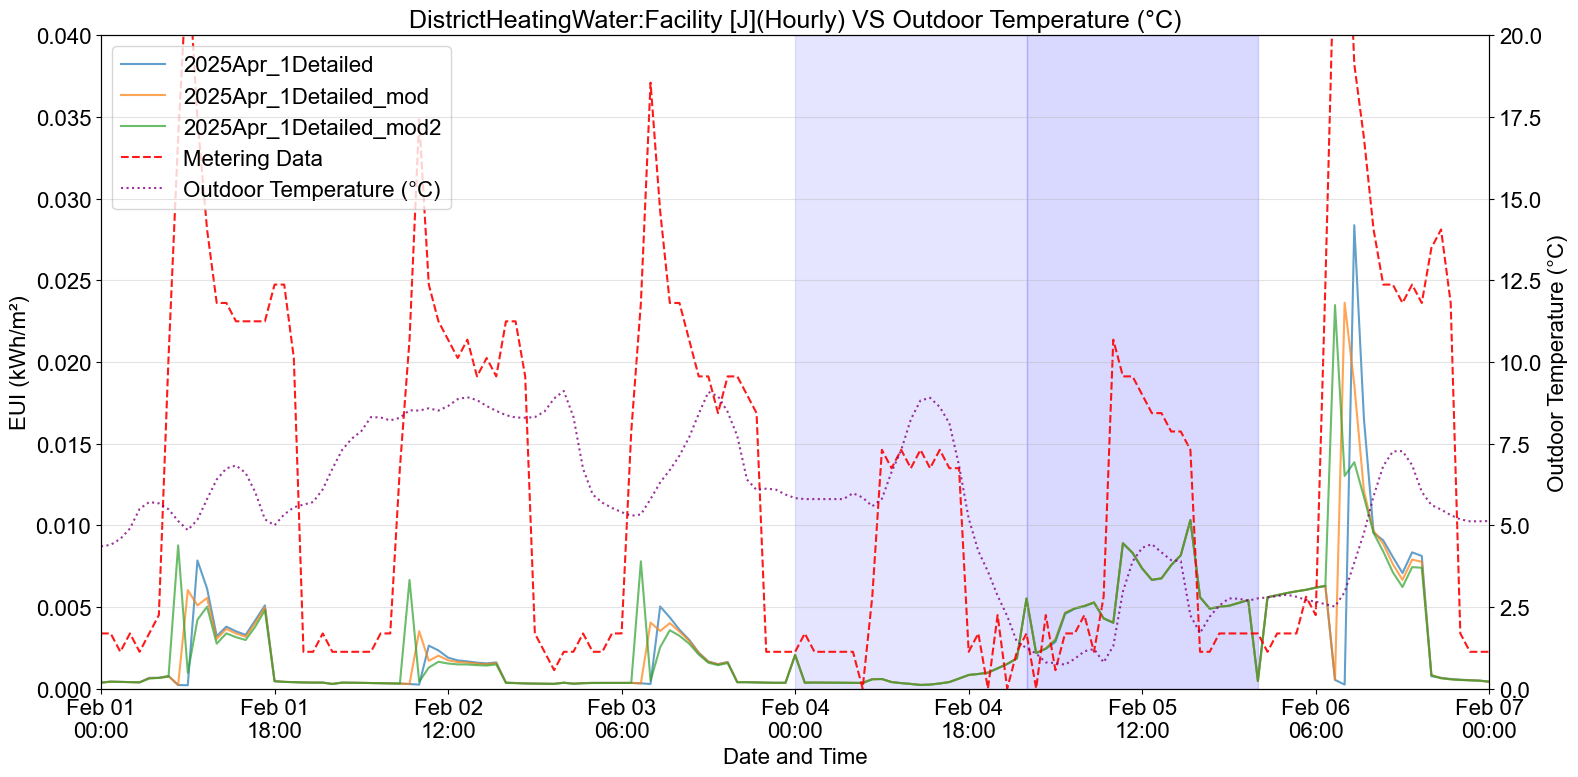

In [58]:
if __name__ == "__main__":
    profiling(
        parent_folder="2025-Apr-Group/Group1: HVAC-Detailed",
        start_date='2023-02-01',
        end_date='2023-02-07',
        energy_columns=['DistrictHeatingWater:Facility [J](Hourly)'],
        metering_file="/Users/rui.bo/Downloads/Statistics/BldgBC/Metering.csv",
        metering_column="Main Heating",
        num_ticks=9,
        area=8894,
        aux_column="T_out",  # auxiliary data
        aux_label="Outdoor Temperature (°C)",
        aux_color="purple",
        aux_scale=1.0,
        aux_linestyle=":",
        aux_alpha=0.8,
        holidays=None
        )